# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from datetime import datetime
from networkx.algorithms import community


# Fetch Cryptocurrency Data

In [41]:
def fetch_crypto_data(tickers, start_date, end_date):
    """Fetch cryptocurrency data from Yahoo Finance."""
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        if 'Close' in df.columns:
            data[ticker] = df['Close']
    return pd.DataFrame(data)

# Define tickers and date range
tickers = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD', 'BCH-USD', 'ADA-USD']
start_date = '2020-01-01'
end_date = '2022-12-31'

# Fetch price data
prices_df = fetch_crypto_data(tickers, start_date, end_date)
prices_df.head()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,BTC-USD,ETH-USD,XRP-USD,LTC-USD,BCH-USD,ADA-USD
Date,,,,,,
2020-01-01,7200.174316,130.802002,0.192667,42.017719,204.397537,0.033458
2020-01-02,6985.470215,127.410179,0.188043,39.823013,195.698563,0.032751
2020-01-03,7344.884277,134.171707,0.193521,42.415573,222.412979,0.034180
2020-01-04,7410.656738,135.069366,0.194355,43.326607,226.018692,0.034595
2020-01-05,7411.317383,136.276779,0.195537,43.553207,224.096527,0.034721


# Calculate Logarithmic Returns

In [44]:
def calculate_returns(prices_df):
    """Calculate daily logarithmic returns."""
    return np.log(prices_df) - np.log(prices_df.shift(1))

# Calculate returns
returns_df = calculate_returns(prices_df)
returns_df.head()


,BTC-USD,ETH-USD,XRP-USD,LTC-USD,BCH-USD,ADA-USD
Date,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,-0.030273,-0.026273,-0.024293,-0.053646,-0.043491,-0.021357
2020-01-03,0.050172,0.051709,0.028715,0.063071,0.127960,0.042707
2020-01-04,0.008915,0.006668,0.004300,0.021251,0.016082,0.012069
2020-01-05,0.000089,0.008899,0.006063,0.005216,-0.008541,0.003635


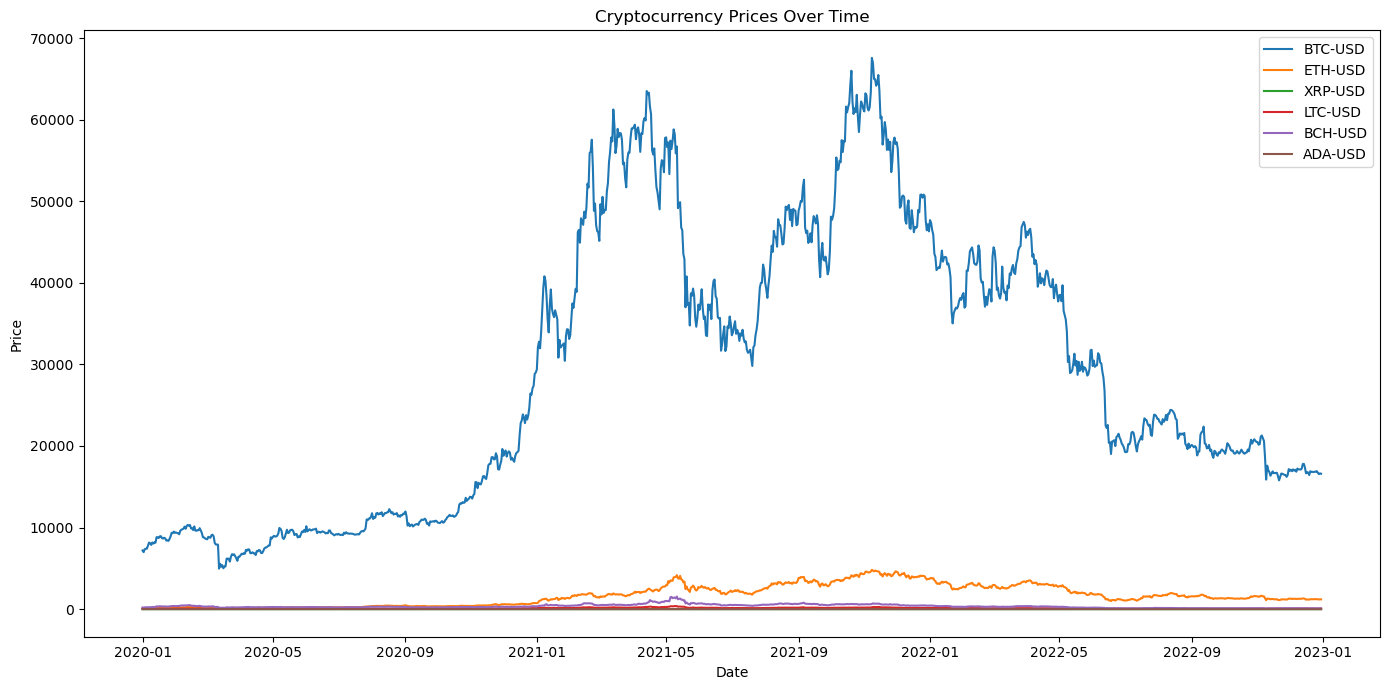

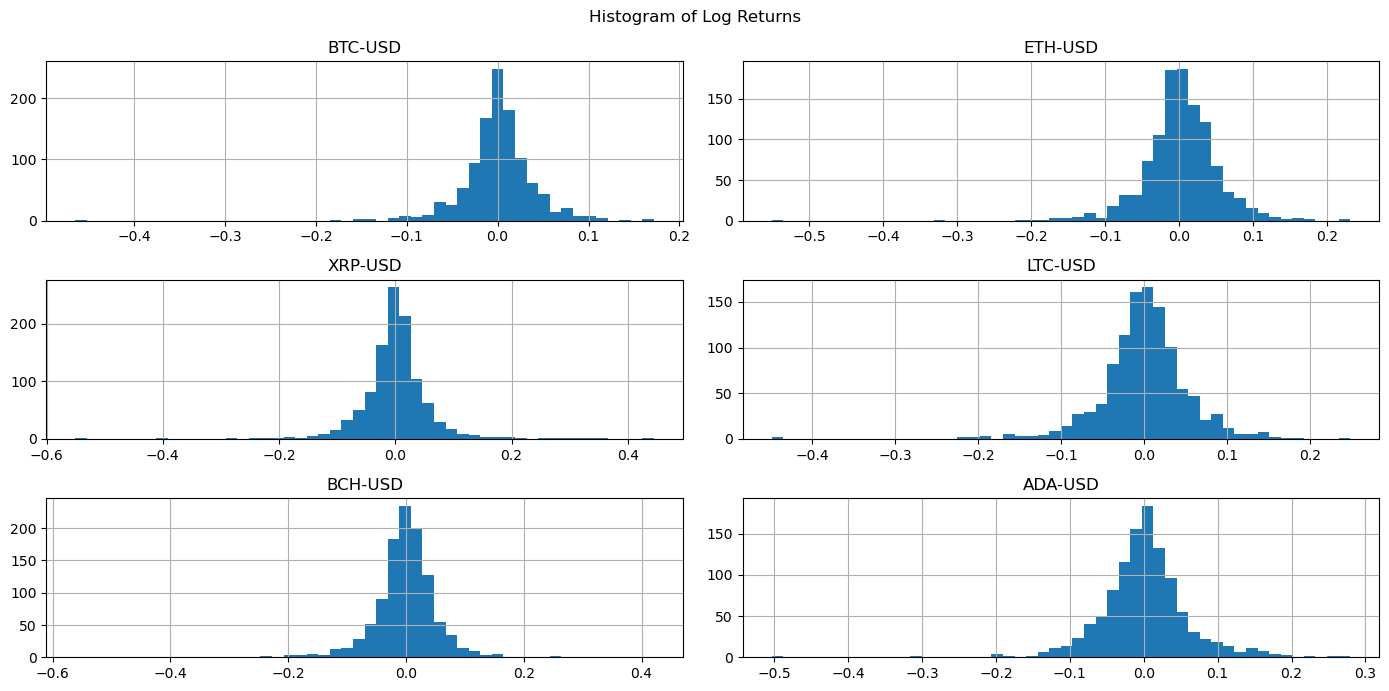

,BTC-USD,ETH-USD,XRP-USD,LTC-USD,BCH-USD,ADA-USD
Date,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,-0.030273,-0.026273,-0.024293,-0.053646,-0.043491,-0.021357
2020-01-03,0.050172,0.051709,0.028715,0.063071,0.127960,0.042707
2020-01-04,0.008915,0.006668,0.004300,0.021251,0.016082,0.012069
2020-01-05,0.000089,0.008899,0.006063,0.005216,-0.008541,0.003635
...,...,...,...,...,...,...
2022-12-26,0.004610,0.006552,0.054305,0.021138,0.019857,0.022980
2022-12-27,-0.012048,-0.011626,0.006549,-0.027783,-0.016512,-0.018746
2022-12-28,-0.009895,-0.018983,-0.032004,-0.035667,-0.025039,-0.047152


In [67]:
def eda_prices_and_returns(prices_df):
    """Perform basic EDA on price data."""
    # Plot closing prices
    plt.figure(figsize=(14, 7))
    for column in prices_df.columns:
        plt.plot(prices_df[column], label=column)
    plt.title("Cryptocurrency Prices Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate and plot log returns
    returns_df = calculate_returns(prices_df)
    returns_df.hist(bins=50, figsize=(14, 7))
    plt.suptitle("Histogram of Log Returns")
    plt.tight_layout()
    plt.show()

    return returns_df
eda_prices_and_returns(prices_df)


# Analyze Hurst Exponents

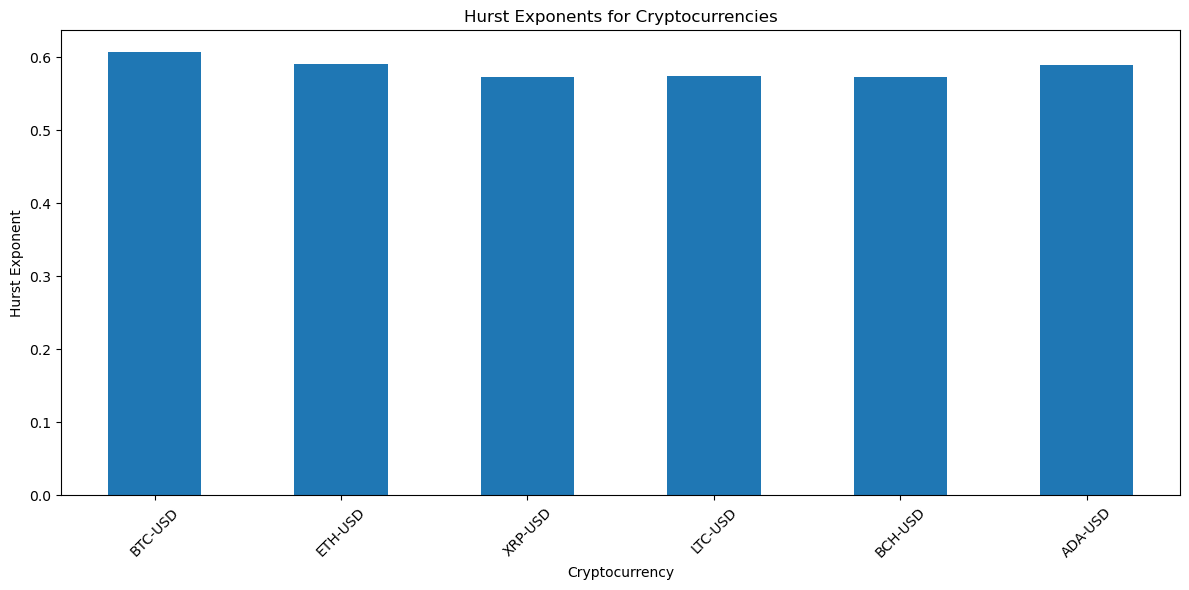


Hurst Exponent Analysis:
BTC-USD: 0.61 (persistent/trending)
ETH-USD: 0.59 (random walk)
XRP-USD: 0.57 (random walk)
LTC-USD: 0.57 (random walk)
BCH-USD: 0.57 (random walk)
ADA-USD: 0.59 (random walk)


In [49]:
def calculate_hurst_exponent(time_series):
    """Calculate Hurst exponent using R/S analysis."""
    time_series = time_series.dropna()
    lags = [2**x for x in range(4, int(np.log2(len(time_series) / 2)))]
    rs_values = []
    for lag in lags:
        chunks = len(time_series) // lag
        if chunks == 0:
            continue
        rs_chunk = []
        for i in range(chunks):
            chunk = time_series[i * lag:(i + 1) * lag]
            mean_adj = chunk - chunk.mean()
            cumsum = mean_adj.cumsum()
            r = cumsum.max() - cumsum.min()
            s = chunk.std()
            if s != 0:
                rs_chunk.append(r / s)
        if rs_chunk:
            rs_values.append(np.mean(rs_chunk))
    if len(lags) > 1 and len(rs_values) > 1:
        log_lags = np.log10(lags[:len(rs_values)])
        log_rs = np.log10(rs_values)
        hurst = np.polyfit(log_lags, log_rs, 1)[0]
        return hurst
    return np.nan

def analyze_hurst_exponents(returns_df):
    """Calculate and analyze Hurst exponents for all cryptocurrencies."""
    hurst_values = {}
    for column in returns_df.columns:
        hurst = calculate_hurst_exponent(returns_df[column])
        hurst_values[column] = hurst
    
    hurst_df = pd.DataFrame.from_dict(hurst_values, orient='index', columns=['Hurst'])
    plt.figure(figsize=(12, 6))
    hurst_df['Hurst'].plot(kind='bar')
    plt.title('Hurst Exponents for Cryptocurrencies')
    plt.xlabel('Cryptocurrency')
    plt.ylabel('Hurst Exponent')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\nHurst Exponent Analysis:")
    for crypto, hurst in hurst_values.items():
        if hurst < 0.45:
            interpretation = "mean-reverting"
        elif 0.45 <= hurst < 0.60:
            interpretation = "random walk"
        else:
            interpretation = "persistent/trending"
        print(f"{crypto}: {hurst:.2f} ({interpretation})")

# Analyze Hurst Exponents
analyze_hurst_exponents(returns_df)


# Correlation Heatmap

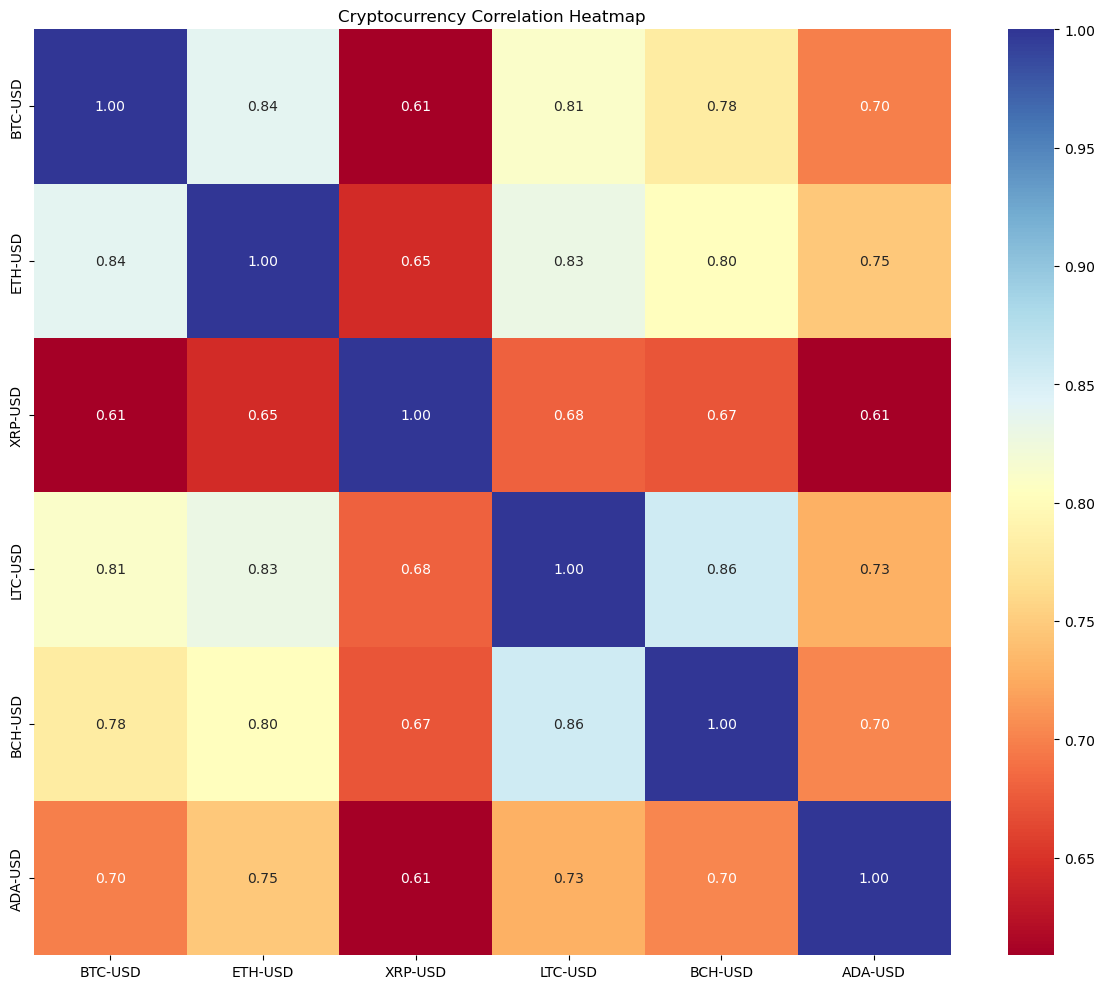

In [52]:
def create_correlation_heatmap(corr_matrix):
    """Plot correlation heatmap."""
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu', cbar=True)
    plt.title('Cryptocurrency Correlation Heatmap')
    plt.tight_layout()
    plt.show()

# Compute correlation matrix and plot heatmap
corr_matrix = returns_df.corr()
create_correlation_heatmap(corr_matrix)


# Dendrogram for Hierarchical Clustering

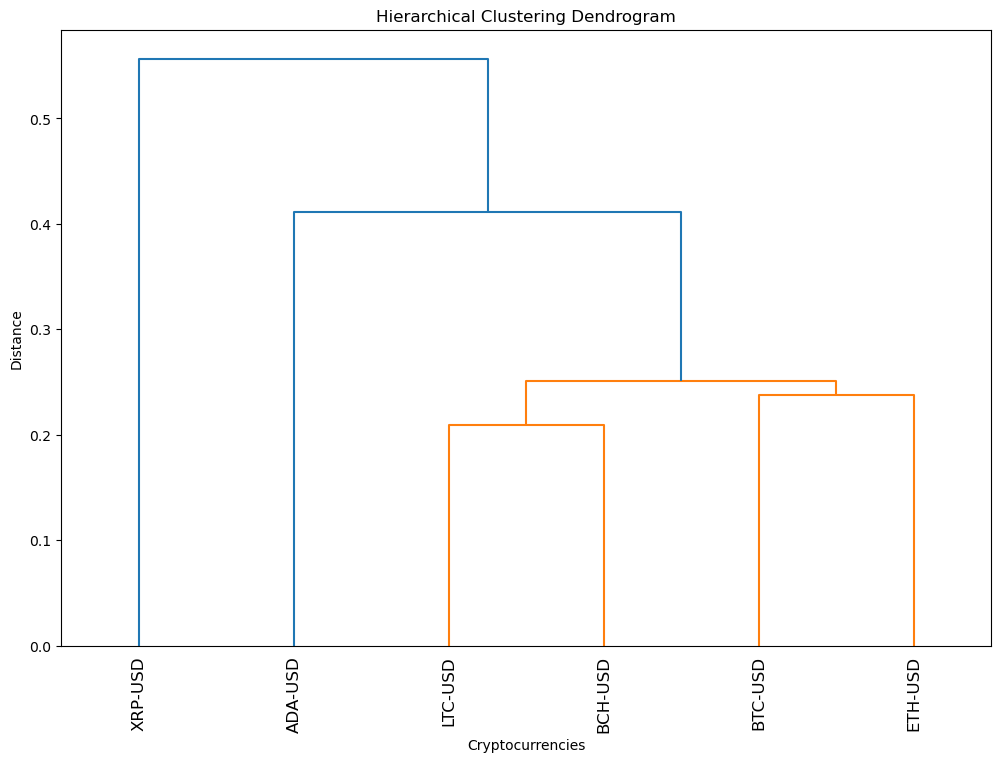

In [55]:
def create_dendrogram(corr_matrix):
    """Create and visualize hierarchical clustering dendrogram."""
    dist_matrix = hierarchy.distance.pdist(corr_matrix)
    linkage = hierarchy.linkage(dist_matrix, method='single')
    plt.figure(figsize=(12, 8))
    hierarchy.dendrogram(linkage, labels=corr_matrix.index, leaf_rotation=90)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Cryptocurrencies')
    plt.ylabel('Distance')
    plt.show()

# Create dendrogram
create_dendrogram(corr_matrix)


# Minimum Spanning Tree (MST)



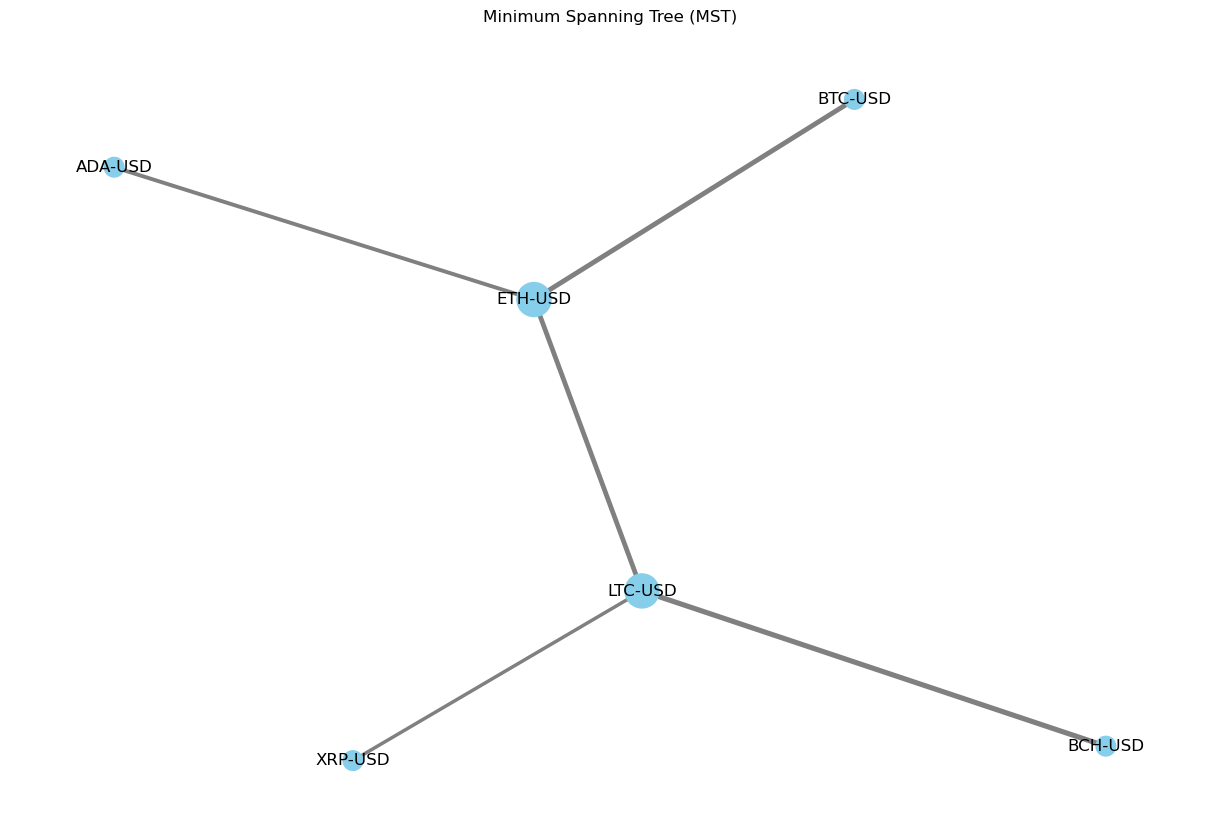

In [58]:
def create_distance_matrix(corr_matrix):
    """Create distance matrix from correlation matrix."""
    return np.sqrt(2 * (1 - corr_matrix))

def create_mst(distance_matrix, cryptocurrencies):
    """Create and visualize Minimum Spanning Tree."""
    G = nx.Graph()
    for i in range(len(cryptocurrencies)):
        for j in range(i + 1, len(cryptocurrencies)):
            G.add_edge(cryptocurrencies[i], cryptocurrencies[j],
                       weight=distance_matrix.iloc[i, j])
    mst = nx.minimum_spanning_tree(G)
    centrality = nx.degree_centrality(mst)
    pos = nx.spring_layout(mst, seed=42)
    plt.figure(figsize=(12, 8))
    nx.draw(mst, pos, with_labels=True, 
            node_size=[v * 1000 for v in centrality.values()],
            width=[2 / d['weight'] for u, v, d in mst.edges(data=True)],
            node_color='skyblue', edge_color='gray')
    plt.title('Minimum Spanning Tree (MST)')
    plt.axis('off')
    plt.show()
    return mst

# Compute distance matrix and MST
dist_matrix = create_distance_matrix(corr_matrix)
mst = create_mst(dist_matrix, returns_df.columns)


# Advanced Network Analysis

In [61]:
def advanced_network_analysis(mst):
    """Perform advanced network analysis."""
    degree_centrality = nx.degree_centrality(mst)
    closeness_centrality = nx.closeness_centrality(mst)
    betweenness_centrality = nx.betweenness_centrality(mst)

    print("\nAdvanced Network Analysis:")
    print("Degree Centrality:", degree_centrality)
    print("Closeness Centrality:", closeness_centrality)
    print("Betweenness Centrality:", betweenness_centrality)

    communities = community.greedy_modularity_communities(mst)
    print("\nCommunities Detected:")
    for i, comm in enumerate(communities):
        print(f"Community {i + 1}: {list(comm)}")

# Perform advanced network analysis
advanced_network_analysis(mst)



Advanced Network Analysis:
Degree Centrality: {'BTC-USD': 0.2, 'ETH-USD': 0.6000000000000001, 'XRP-USD': 0.2, 'LTC-USD': 0.6000000000000001, 'BCH-USD': 0.2, 'ADA-USD': 0.2}
Closeness Centrality: {'BTC-USD': 0.45454545454545453, 'ETH-USD': 0.7142857142857143, 'XRP-USD': 0.45454545454545453, 'LTC-USD': 0.7142857142857143, 'BCH-USD': 0.45454545454545453, 'ADA-USD': 0.45454545454545453}
Betweenness Centrality: {'BTC-USD': 0.0, 'ETH-USD': 0.7000000000000001, 'XRP-USD': 0.0, 'LTC-USD': 0.7000000000000001, 'BCH-USD': 0.0, 'ADA-USD': 0.0}

Communities Detected:
Community 1: ['BTC-USD', 'ETH-USD', 'ADA-USD']
Community 2: ['XRP-USD', 'BCH-USD', 'LTC-USD']
